In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json


In [4]:
import proteomics_functions as prot_fun

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

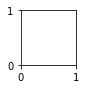

In [5]:
fig, ax = my_plot.instantiate_fig(1, 1)

In [11]:
df_aex = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')
df_prev = pd.read_csv('../2022-09-20_sec_proteomics/generated_tables/swath_master_df_ppm.csv')
df_prop = pd.read_csv('./generated_tables/swath_master_df_ppm_with_properties.csv')
df_prev_prop = pd.read_csv('../2022-09-20_sec_proteomics/generated_tables/swath_master_df_ppm_with_properties.csv')

df_all = df_prev.merge(df_aex, how='outer')
df_all = df_all.fillna(0)

df_log = df_all.drop(columns=['accn', 'name'])
df_log = df_log.fillna(0)
df_log = np.log10(df_log)
df_log.replace(-1*np.inf, np.nan, inplace=True)

In [7]:
resins = ['cq', 'xq', 'hq']
fracs = ['a5', 'b12', 'd9', 'g12', 'eluate']
loadings = ['5% Loading', '28% Loading', '53% Loading', '99% Loading', 'Adsorbate']

resin_names = {'cq':'Capto Q', 'xq':'Poros XQ', 'hq':'Poros 50 HQ'}
frac_names = {'a5':'A5', 'b12':'B12', 'd9':'D9', 'g12':'G12', 'eluate':'Adsorbate'}
percent_loading = {'a5':'5%', 'b12':'28%', 'd9':'53%', 'g12':'99%', 'eluate':'Adsorbate'}

# $c$ distributions - violin plots

In [20]:
log10_label = r'$\mathsf{log_{10}\left(c_{HCP} \; [ppm \; = \; ng \; HCP \; / \; mg \; total]\right)}$'

sample = 'pavin_feed'
df_violin = pd.DataFrame()
df_violin[log10_label] = df_log[df_log[sample].notnull()][sample].copy()
df_violin['sample_name'] = 'PAVIN Feed'

for resin in resins:
    for frac in fracs:
        sample = f'{resin}_{frac}'
        label = f'{resin_names[resin]} {percent_loading[frac]}'
        df_temp = pd.DataFrame()
        df_temp[log10_label] = df_log[df_log[sample].notnull()][sample].copy()
        df_temp['sample_name'] = label
        df_violin = pd.concat([df_violin, df_temp], ignore_index=True)

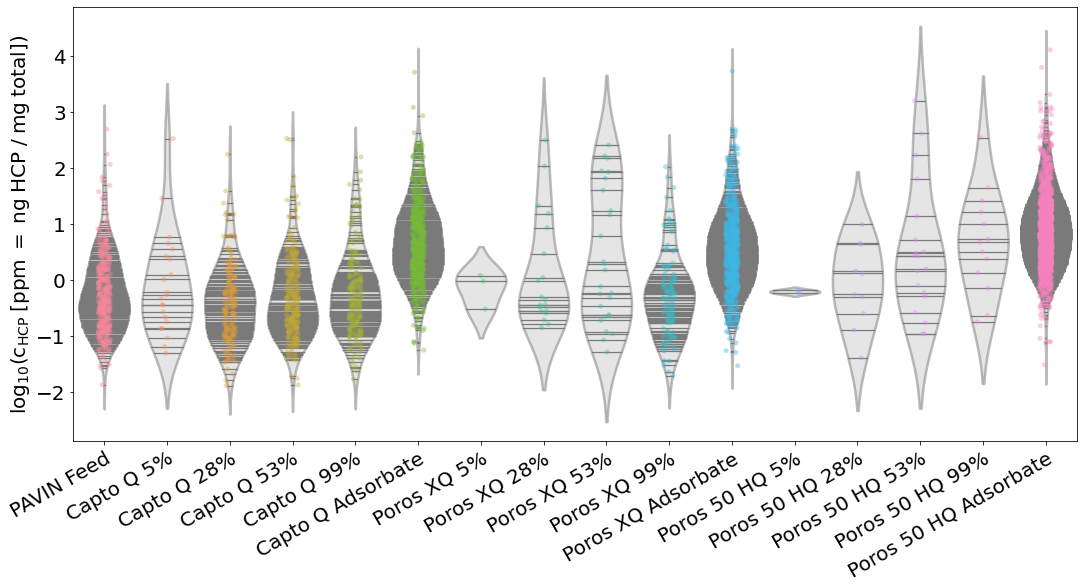

In [64]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = log10_label
df = df_violin

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, linewidth=2.5, scale='width', color='0.8', inner='stick')

# for artist in ax.lines:
#     artist.set_zorder(10)
# for artist in ax.findobj(PathCollection):
#     artist.set_zorder(11)

for violin in ax.collections:
    violin.set_alpha(0.5)

strip = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, ax=ax, alpha=0.4)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

# plt.savefig('./images/6_c_HCP_violin.png', dpi=300, bbox_inches='tight')

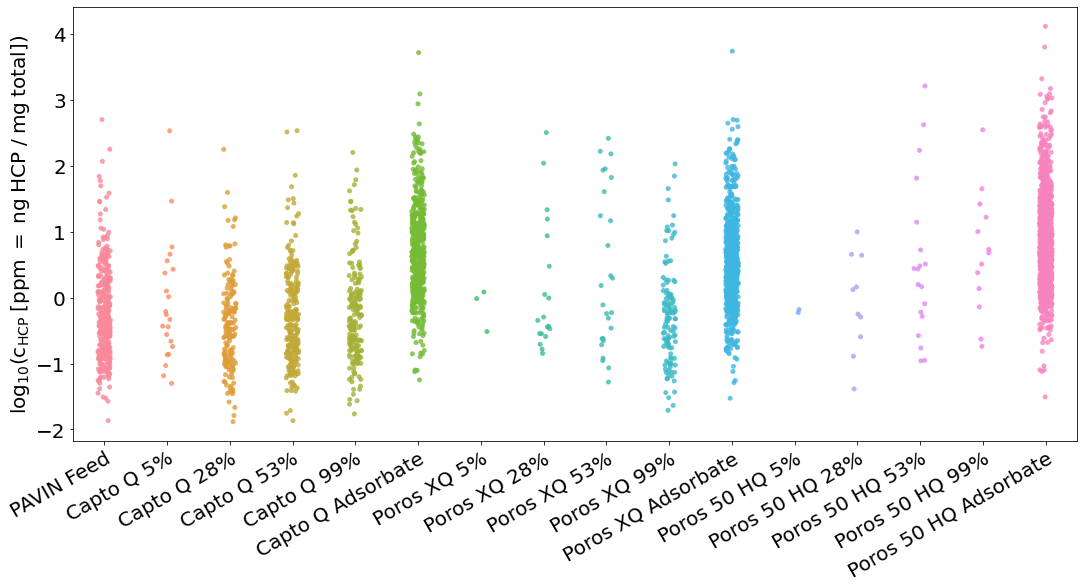

In [10]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = log10_label
df = df_violin

ax = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, alpha=0.8)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

# plt.savefig('./images/6_c_HCP_strip.png', dpi=300, bbox_inches='tight')

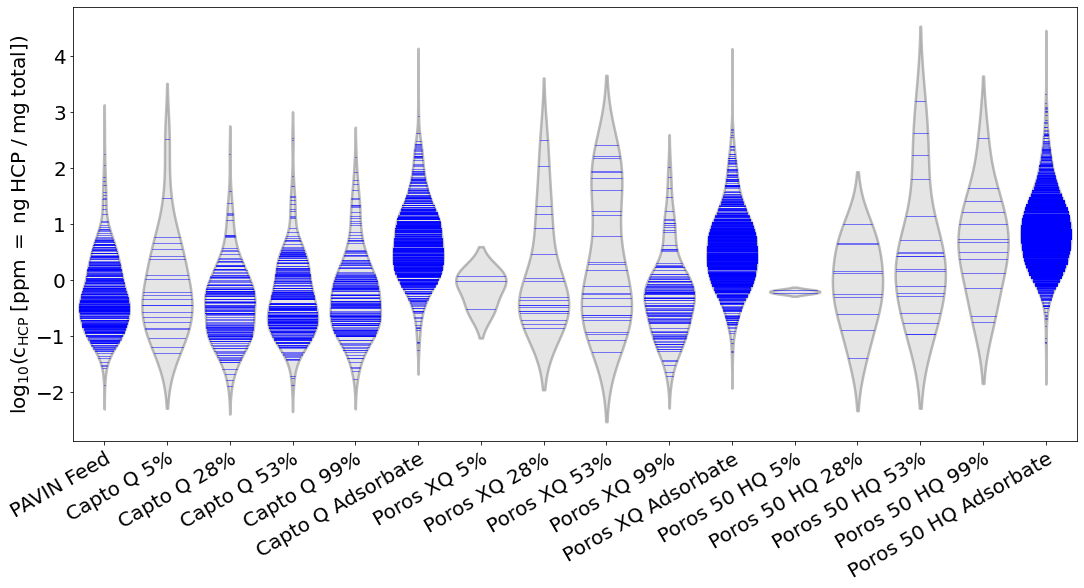

In [82]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = log10_label
df = df_violin

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, linewidth=2.5, scale='width', color='0.8', inner='stick')

for violin in ax.collections:
    violin.set_alpha(0.5)
    
for line in ax.lines:
    line.set_color('blue')
    line.set_linewidth(0.5)
    

labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

# plt.savefig('./images/6_c_HCP_violin.png', dpi=300, bbox_inches='tight')

# pI

In [13]:
violin_label = 'Isoelectric point'
prop = 'pI'

sample = 'pavin_feed'
df_violin = pd.DataFrame()
df_violin[violin_label] = df_prev_prop[df_prev_prop[sample] > 0.0][prop].copy()
df_violin['sample_name'] = 'PAVIN Feed'

for resin in resins:
    for frac in fracs:
        sample = f'{resin}_{frac}'
        df_temp = pd.DataFrame()
        df_temp[violin_label] = df_prop[df_prop[sample] > 0.0][prop].copy()
        df_temp['sample_name'] = f'{resin_names[resin]} {percent_loading[frac]}'
        df_violin = pd.concat([df_violin, df_temp], ignore_index=True)

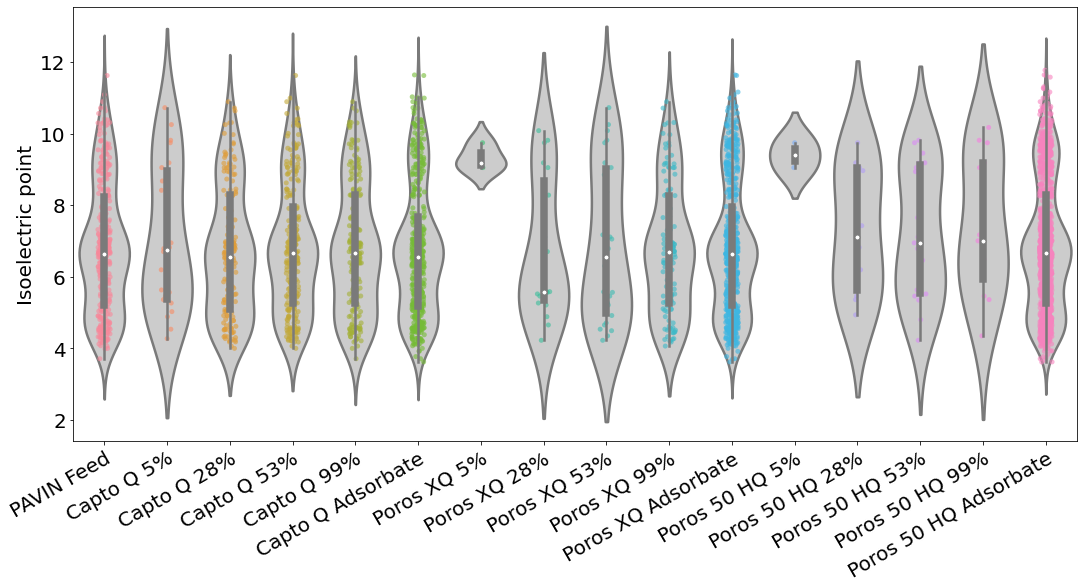

In [14]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = violin_label
df = df_violin

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, color=".8", linewidth=2.5, scale='width')

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, ax=ax, alpha=0.6)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

# plt.savefig('./images/6_pI_violin.png', dpi=300, bbox_inches='tight')

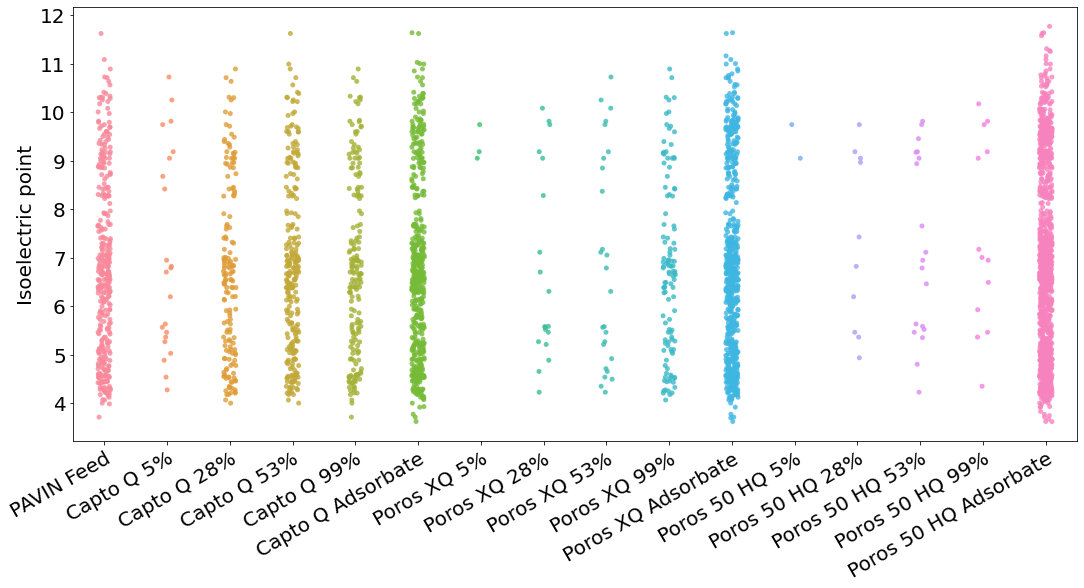

In [15]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = violin_label
df = df_violin

ax = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, alpha=0.8)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

# plt.savefig('./images/6_pI_strip.png', dpi=300, bbox_inches='tight')

# Mass

In [16]:
violin_label = 'Molecular mass [kDa]'
prop = 'mass'

sample = 'pavin_feed'
df_violin = pd.DataFrame()
df_violin[violin_label] = df_prev_prop[df_prev_prop[sample] > 0.0][prop].copy()
df_violin['sample_name'] = 'PAVIN Feed'

for resin in resins:
    for frac in fracs:
        sample = f'{resin}_{frac}'
        df_temp = pd.DataFrame()
        df_temp[violin_label] = df_prop[df_prop[sample] > 0.0][prop].copy()
        df_temp['sample_name'] = f'{resin_names[resin]} {percent_loading[frac]}'
        df_violin = pd.concat([df_violin, df_temp], ignore_index=True)
        
df_violin[violin_label] *= 1e-3

(0.0, 890.7141623800057)

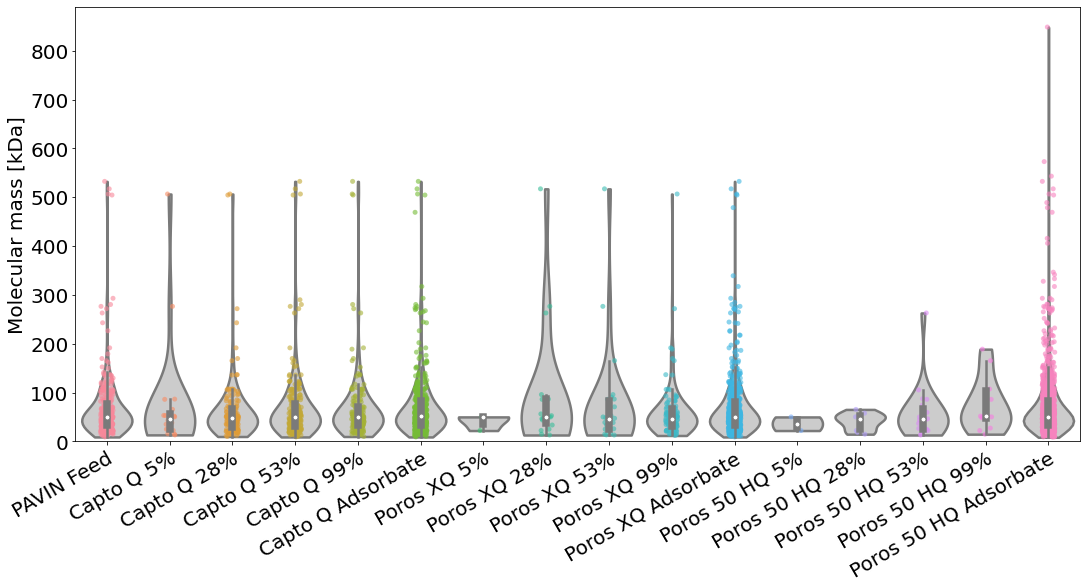

In [17]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = violin_label
df = df_violin

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, color=".8", linewidth=2.5, scale='width', cut=0)

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, ax=ax, alpha=0.6)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
ax.set_ylim(0, None)

# plt.savefig('./images/6_mass_violin.png', dpi=300, bbox_inches='tight')

(0.0, 890.7141623800057)

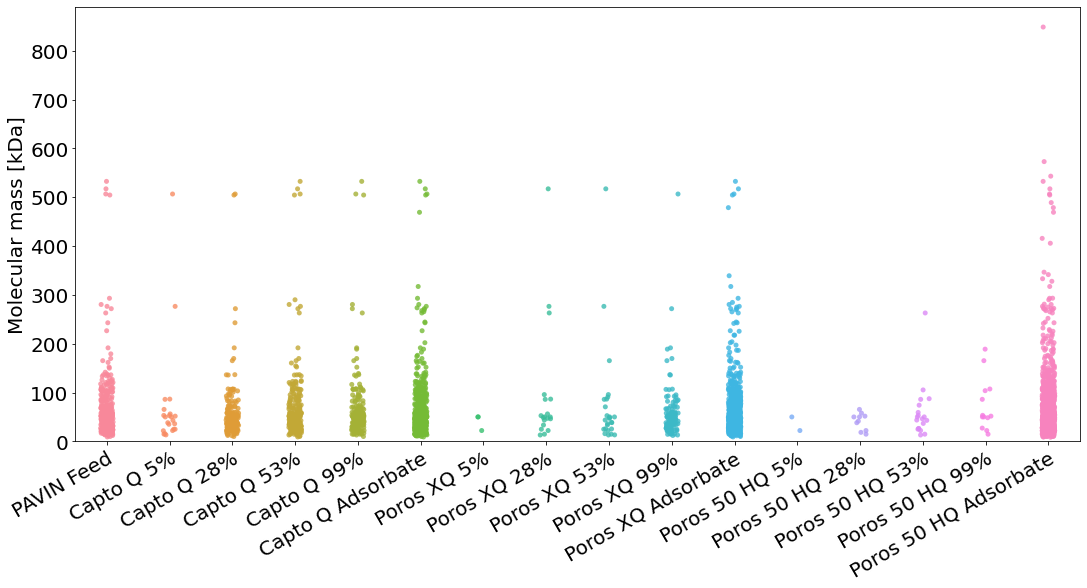

In [18]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = violin_label
df = df_violin

ax = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, alpha=0.8)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
ax.set_ylim(0, None)

# plt.savefig('./images/6_mass_strip.png', dpi=300, bbox_inches='tight')